In [22]:
# COVID-19 Clustering Analysis for Google Colab

# Install required libraries (if not already installed)
!pip install pandas numpy scikit-learn matplotlib seaborn openpyxl

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
import pandas as pd
file_path = "Gov_Responses2Covid19_last.xlsx"
df = pd.read_excel(file_path, sheet_name="Dataset")
df.head()


,country,geoid,iso,d,cases,deaths,school,school_local,domestic,domestic_local,...,wage,credit,taxc,taxd,export,rate,Rigidity_Public_Health,Economic_Measures,population_2019,continent
0,Aruba,AW,ABW,2020-01-01 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
1,Aruba,AW,ABW,2020-01-02 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
2,Aruba,AW,ABW,2020-01-03 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
3,Aruba,AW,ABW,2020-01-04 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
4,Aruba,AW,ABW,2020-01-05 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America


In [24]:
# Forward-fill and backward-fill for categorical policy measures within each country
policy_cols = ['school', 'school_local', 'masks', 'masks_partial', 'domestic', 'domestic_local',
               'travel', 'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf', 'curf_partial',
               'mass', 'mass_partial', 'elect', 'elect_partial', 'sport', 'sport_partial', 'rest',
               'rest_local', 'testing', 'testing_narrow', 'surveillance', 'surveillance_partial',
               'state', 'state_partial']

df[policy_cols] = df.groupby(['geoid', 'country'], group_keys=False)[policy_cols].apply(lambda group: group.ffill().bfill())

# Fill remaining missing policy values with 0 (assuming no policy intervention)
df[policy_cols] = df[policy_cols].fillna(0)

# Linear interpolation for economic measures within each country
economic_cols = ['wage', 'taxc', 'credit', 'cash', 'export', 'rate', 'Economic_Measures']
df[economic_cols] = df.groupby(['geoid', 'country'], group_keys=False)[economic_cols].apply(lambda group: group.interpolate(method='linear'))

# Fill remaining missing economic values with 0 (assuming no intervention)
df[economic_cols] = df[economic_cols].fillna(0)

# Rolling average for cases and deaths (7-day window)
df[['cases', 'deaths']] = df.groupby(['geoid', 'country'], group_keys=False)[['cases', 'deaths']].apply(
    lambda group: group.fillna(group.rolling(7, min_periods=1).mean())
)

# Fill remaining missing cases & deaths with 0
df[['cases', 'deaths']] = df[['cases', 'deaths']].fillna(0)

# Drop election-related variables (optional)
df.drop(columns=['elect', 'elect_partial'], errors='ignore', inplace=True)

# Mean imputation for population within the same continent
df['population_2019'] = df.groupby('continent')['population_2019'].transform(lambda x: x.fillna(x.mean()))

# Fill missing continent values using most frequent value (mode)
df['continent'].fillna(df['continent'].mode()[0], inplace=True)

# Fill missing geoid with country ISO code (if applicable)
df['geoid'].fillna(df['iso'], inplace=True)

df['taxd'].fillna(0, inplace=True)
df['Rigidity_Public_Health'].fillna(0, inplace=True)

# Fill remaining missing population with global mean
df['population_2019'].fillna(df['population_2019'].mean(), inplace=True)

df['d'] = pd.to_datetime(df['d'])

# Ensure index alignment
df.reset_index(drop=True, inplace=True)

# Check missing values again
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


<ipython-input-24-17379237d9c0>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['continent'].fillna(df['continent'].mode()[0], inplace=True)
<ipython-input-24-17379237d9c0>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace


--- Cluster Characteristics Interpretation ---

Cluster 0:
Key Characteristics:
- cases: 1159.22
- deaths: 34.41
- travel: 0.87
- school: 0.84
- mass: 0.84
Significant Deviations from Overall Mean:
  * cases: 88.69% increase
  * deaths: 89.71% increase
  * Rigidity_Public_Health: 69.01% increase
  * school: 55.63% increase
  * domestic: 76.91% increase
  * travel: 64.87% increase
  * curf: 73.86% increase
  * mass: 71.60% increase
  * masks: 76.62% increase
  * state: 68.82% increase
  * testing: 72.58% increase
  * Economic_Measures: 82.45% increase
  * cash: 88.31% increase
  * wage: 78.88% increase
  * credit: 82.87% increase
  * taxc: 83.87% increase
  * taxd: 83.32% increase
  * export: 85.77% increase
  * rate: 75.89% increase

Cluster 1:
Key Characteristics:
- cases: 19.82
- deaths: 0.38
- school: 0.21
- travel: 0.15
- mass: 0.11
Significant Deviations from Overall Mean:
  * cases: 96.77% decrease
  * deaths: 97.89% decrease
  * Rigidity_Public_Health: 75.30% decrease
  * schoo

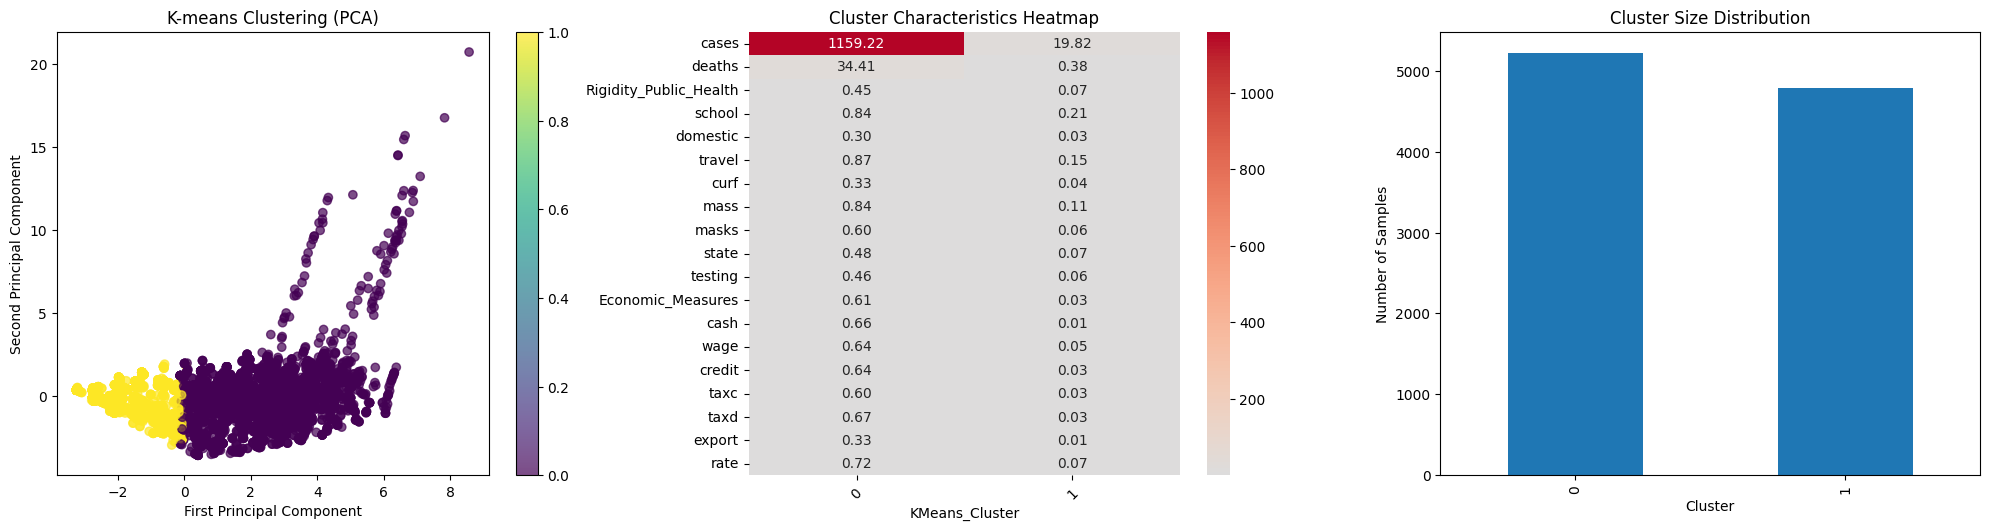

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def select_features(df):
    """
    Select relevant features for clustering analysis
    """
    clustering_features = [
        # Epidemiological Features
        'cases', 'deaths',

        # Public Health Intervention Features
        'Rigidity_Public_Health',
        'school', 'domestic', 'travel', 'curf',
        'mass', 'masks', 'state', 'testing',

        # Economic Response Features
        'Economic_Measures',
        'cash', 'wage', 'credit',
        'taxc', 'taxd', 'export', 'rate'
    ]

    # Create a subset of the dataframe with selected features
    available_features = [f for f in clustering_features if f in df.columns]

    # Drop rows with missing values in selected features
    return df[available_features].dropna()

def preprocess_data(df, max_features=10):
    """
    Preprocess data with dimensionality reduction and standardization
    """
    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(max_features, scaled_data.shape[1]))
    reduced_data = pca.fit_transform(scaled_data)

    return reduced_data, pca, scaler, df

def visualize_clusters_detailed(reduced_data, kmeans_labels, hierarchical_labels, original_df, pca):
    """
    Create comprehensive visualization and cluster interpretation
    """
    plt.figure(figsize=(20,10))

    # PCA Scatter Plot
    plt.subplot(2,3,1)
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1],
                          c=kmeans_labels,
                          cmap='viridis',
                          alpha=0.7)
    plt.title('K-means Clustering (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)

    # Cluster Characteristics Heatmap
    plt.subplot(2,3,2)
    cluster_means = original_df.copy()
    cluster_means['KMeans_Cluster'] = kmeans_labels
    cluster_avg = cluster_means.groupby('KMeans_Cluster').mean()

    sns.heatmap(cluster_avg.T, cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Cluster Characteristics Heatmap')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Cluster Size Distribution
    plt.subplot(2,3,3)
    cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
    cluster_counts.plot(kind='bar')
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')

    # Detailed Cluster Interpretation
    print("\n--- Cluster Characteristics Interpretation ---")
    for cluster in cluster_avg.index:
        print(f"\nCluster {cluster}:")
        print("Key Characteristics:")

        # Identify top distinguishing features
        cluster_profile = cluster_avg.loc[cluster]
        top_features = cluster_profile.abs().nlargest(5)

        for feature, value in top_features.items():
            print(f"- {feature}: {value:.2f}")

        # Comparative analysis
        overall_mean = original_df.mean()
        deviation = abs((cluster_profile - overall_mean) / overall_mean * 100)
        significant_deviations = deviation[deviation > 50]

        if not significant_deviations.empty:
            print("Significant Deviations from Overall Mean:")
            for feature, dev in significant_deviations.items():
                print(f"  * {feature}: {dev:.2f}% {'increase' if cluster_profile[feature] > overall_mean[feature] else 'decrease'}")

    plt.tight_layout()
    plt.show()

def perform_advanced_clustering(df, sample_size=10000, max_clusters=6):
    """
    Perform advanced clustering with detailed visualization and interpretation
    """
    # Sample the dataframe if it's too large
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Select and preprocess features
    clustered_df = select_features(df)
    reduced_data, pca, scaler, original_df = preprocess_data(clustered_df)

    # K-means Clustering
    kmeans_silhouette_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = MiniBatchKMeans(
            n_clusters=k,
            batch_size=1000,
            random_state=42,
            n_init=10
        )
        cluster_labels = kmeans.fit_predict(reduced_data)
        kmeans_silhouette_scores.append(silhouette_score(reduced_data, cluster_labels))

    # Find optimal K-means clusters
    optimal_kmeans_k = kmeans_silhouette_scores.index(max(kmeans_silhouette_scores)) + 2

    # Final K-means clustering
    final_kmeans = MiniBatchKMeans(
        n_clusters=optimal_kmeans_k,
        batch_size=1000,
        random_state=42,
        n_init=10
    )
    kmeans_labels = final_kmeans.fit_predict(reduced_data)

    # Visualization and Interpretation
    visualize_clusters_detailed(reduced_data, kmeans_labels, None, original_df, pca)

    return kmeans_labels

# Example usage
results = perform_advanced_clustering(df)

# Clustering Analysis